## Neural Network Implementation

This is our first implentation of a Neural Network. This notebook borrows heavily from [this](https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU) youtube series and [this](https://github.com/stephencwelch/Neural-Networks-Demystified) accompanying repo.

In [1]:
import numpy as np
from scipy import optimize
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Let's initialize our inputs and outputs. `X` is a matrix with 2 features and 3 samples, `y` is a vector with 3 samples. Note that we normalize `y` so that its max value is `1.0`. This will become important later.

In [2]:
X = np.array(([3,5], [5,1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

# Normalize
X = X/np.amax(X, axis=0)
y = y/100  # Max test score is 100

Here's the Neural Network class! We won't go in depth on explaining everything going on in here because the youtube videos and git repo do so better than we could. One thing we did find really interesting that the video glossed over was that the sigmoid function is applied to the output layer. This makes it so that our network can only make predictions from 0-1. If you want your network to predict data that does not fall between 0 and 1, you have to use a slightly different architecture.

In [3]:
class Neural_Network(object):
    def __init__(self):
        np.random.seed(0)  # seed the random number generator for consistent results
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3

        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))


Let's initialize our neural network and make a prediction!

In [4]:
NN = Neural_Network()
yHat = NN.forward(X)
print 'yHat:'
print yHat
print 'y:'
print y

yHat:
[[ 0.67399915]
 [ 0.64461564]
 [ 0.66968583]]
y:
[[ 0.75]
 [ 0.82]
 [ 0.93]]


Those are some pretty terrible predictions. This makes sense though, since we basically randomly initialized our weight matrices and used them to make predictions. There's no reason for the predictions to be accurate. Let's update our weight matrices so that our network becomes better at making predictions.

`trainer` is a class that uses `scipy`'s `optimize` module to update the weight matrices according to the gradients.

In [5]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res


In [6]:
T = trainer(NN)
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 89
         Function evaluations: 96
         Gradient evaluations: 96


In [7]:
yHat = NN.forward(X)
print 'yHat:'
print yHat
print 'y:'
print y

yHat:
[[ 0.74999632]
 [ 0.81999591]
 [ 0.92997684]]
y:
[[ 0.75]
 [ 0.82]
 [ 0.93]]


Wow! These predictions are pretty accurate. In fact, they're *too* accurate. We have fallen victim to a common data scientist pitfall. Our network has learned to perfectly predict the data we trained it on, but it's probably not that good at predicting data it hasn't seen, since it just uses the exact pattern of the train set. There are lots of ways to address this, a common one is to add a [regularizer](https://en.wikipedia.org/wiki/Regularization_(mathematics)) to the cost function. We won't go through the implementation of this, as it's similar to regularizing a linear or logistic regression. You just use the sums of the weights inside the Neural Network.

Just to see what the optimizer is doing, here are some graphs:

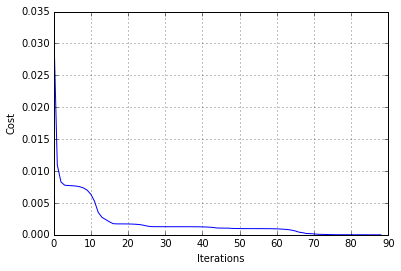

In [8]:
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost')

As you can see, at each iteration the optimizer tweaks the weight matrices so that the network's predictions more accurately match `yHat`.

We can also perform a sanity-check to make sure that the gradients we compute using calculus are actually correct. We do so by computing an approximate numerical gradient, which we can do because of the [limit definition of a derivative](https://www.math.hmc.edu/calculus/tutorials/limit_definition/).

In [9]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 

In [10]:
numgrad = computeNumericalGradient(NN, X, y)
grad = NN.computeGradients(X,y)
print "Numerical gradient"
print numgrad
print "Actual gradient"
print grad

Numerical gradient
[  1.34904098e-07   1.97623342e-06  -6.07620253e-08   1.09120506e-07
   1.76389396e-06  -6.53539629e-08  -2.55880567e-06  -5.86723938e-07
  -2.77263500e-06]
Actual gradient
[  1.34904343e-07   1.97616103e-06  -6.07617572e-08   1.09121625e-07
   1.76337727e-06  -6.53531423e-08  -2.55868640e-06  -5.86719246e-07
  -2.77246933e-06]
